In [2]:
import pandas as pd
import joblib 
import numpy as np
import os
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
bad_classes = [
    "prejudicial language",
    "fallacy of slippery slope",
    "slothful inductesi"
]

In [4]:
all_predictions = os.listdir('cache/predictions/all')
all_predictions = [x for x in all_predictions if x.startswith('outputs_dict')]

In [5]:
data = []
for prediction in all_predictions:
    try:
        outputs_dict = joblib.load('cache/predictions/all/' + prediction)
        outputs_dict['file_name'] = prediction
        if 'meta' in outputs_dict.keys():
            data.append(outputs_dict)
    except Exception as e:
        print(e)
        continue
len(data)

/nas/home/souratih/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


2263

In [6]:
def get_new_data(data, note, dataset = "data/new_finegrained", threshold = None):
    new_data = [
        data_point
        for data_point
        in data
        if data_point["meta"]["data_dir"] == dataset and 'note' in data_point.keys() and (data_point['note'] == note or note == None)
    ]

    if threshold is not None:
        new_data = [
            data_point 
            for data_point in new_data
            if data_point['meta']['cbr_threshold'] == threshold
        ]

    print(len(new_data))
    return new_data

In [7]:
def get_best_model(data, dataset = "data/new_finegrained"):
    best_f1_score = -np.inf
    best_model = None
    
    for x in data:
        if x['meta']['data_dir'] == dataset:
            if x['meta']['f1_score'] > best_f1_score:
                best_f1_score = x['meta']['f1_score']
                best_model = x
    return best_model

In [8]:
def get_metrics(y_true, y_pred):
    return {
        'f1': f1_score(y_true, y_pred, average = "weighted"),
        'precision': precision_score(y_true, y_pred, average = "weighted"),
        'recall': recall_score(y_true, y_pred, average = 'weighted'),
        'accuracy': accuracy_score(y_true, y_pred)
    }

In [9]:
def get_unfolded_labels(sample_data):
    label_encoder = sample_data["label_encoder"]
    cbr_labels = sample_data["cbr_labels"]
    all_cbr_labels = []
    for sample_cbr_labels in cbr_labels:
        unfolded_sample_cbr_labels = []
        for retriever_cbr_samples in sample_cbr_labels:
            for filtered_cbr_sample in retriever_cbr_samples:
                for inner_label in filtered_cbr_sample:
                    unfolded_sample_cbr_labels.append(inner_label)
        all_cbr_labels.append(unfolded_sample_cbr_labels)
        
    all_cbr_labels = [
        label_encoder.transform(cbr_labels)
        for cbr_labels
        in all_cbr_labels
    ]
    return all_cbr_labels

In [10]:
def get_overlap(sample_data):
    label_encoder = sample_data["label_encoder"]
    
    labels = sample_data["predictions"]["label_ids"]
    
    cbr_labels = sample_data["cbr_labels"]
    
    all_cbr_labels = []
    for sample_cbr_labels in cbr_labels:
        unfolded_sample_cbr_labels = []
        for retriever_cbr_samples in sample_cbr_labels:
            for filtered_cbr_sample in retriever_cbr_samples:
                for inner_label in filtered_cbr_sample:
                    unfolded_sample_cbr_labels.append(inner_label)
        all_cbr_labels.append(unfolded_sample_cbr_labels)
        
    all_cbr_labels = [
        label_encoder.transform(cbr_labels)
        for cbr_labels
        in all_cbr_labels
    ]
    
    predicted_labels = np.argmax(sample_data["predictions"]["predictions"], axis = -1)
    correct_predictions = np.where(labels == predicted_labels)[0]

    overlap_count = 0
    for index in correct_predictions:
        if labels[index] in all_cbr_labels[index]:
            overlap_count += 1
    return overlap_count / len(correct_predictions)

In [11]:
def get_results_df(new_data):
    total_cbr_texts = []
    total_cbr_labels = []
    total_num_cases = []
    total_retrievers = []
    total_overlaps = []
    total_thresholds = []
    total_f1_scores = []
    total_precisions = []
    total_recalls = []
    total_accuracies = []
    total_true_labels = []
    total_predicted_labels = []
    total_f1_scores_climate = []
    total_precisions_climate = []
    total_recalls_climate = []
    total_accuracies_climate = []
    for sample_data in new_data:
        if 'cbr_labels' in sample_data.keys():
            total_num_cases.append(sample_data['meta']['num_cases'])
            total_retrievers.append(' '.join(sample_data['meta']["retrievers"]))
            total_cbr_texts.append(sample_data['cbr'])
            total_cbr_labels.append(get_unfolded_labels(sample_data))
            
            total_overlaps.append(get_overlap(sample_data))
            total_thresholds.append(sample_data['meta']['cbr_threshold'])
        else:
            total_cbr_texts.append(None)
            total_cbr_labels.append(None)
            total_num_cases.append(None)
            total_retrievers.append(None)
            total_overlaps.append(None)
            total_thresholds.append(None)
        
        if 'predictions_climate' in sample_data.keys():
            total_f1_scores_climate.append(sample_data['predictions_climate']['metrics']['test_f1'])
            total_precisions_climate.append(sample_data['predictions_climate']['metrics']['test_precision'])
            total_recalls_climate.append(sample_data['predictions_climate']['metrics']['test_recall'])
            total_accuracies_climate.append(sample_data['predictions_climate']['metrics']['test_accuracy'])
        else:
            total_f1_scores_climate.append(None)
            total_precisions_climate.append(None)
            total_recalls_climate.append(None)
            total_accuracies_climate.append(None)
            
        total_f1_scores.append(sample_data['predictions']['metrics']['test_f1'])
        total_precisions.append(sample_data['predictions']['metrics']['test_precision'])
        total_recalls.append(sample_data['predictions']['metrics']['test_recall'])
        total_accuracies.append(sample_data['predictions']['metrics']['test_accuracy'])
        total_true_labels.append(sample_data['predictions']['label_ids'])
        total_predicted_labels.append(
            np.argmax(sample_data['predictions']['predictions'], axis = -1).tolist()
        )
    
    
        
    results_df = pd.DataFrame({
        'num_cases': total_num_cases,
        'threshold': total_thresholds,
        'retrievers': total_retrievers,
        'overlaps': total_overlaps,
        'f1': total_f1_scores,
        'precision': total_precisions,
        'recall': total_recalls,
        'accuracy': total_accuracies,
        'cbr': np.array(total_cbr_texts).squeeze().tolist(),
        'cbr_labels': np.array(total_cbr_labels).squeeze().tolist(),
        'label_ids': total_true_labels,
        'predicted_labels': total_predicted_labels,
        'f1_climate': total_f1_scores_climate,
        'precision_climate': total_precisions_climate,
        'recall_climate': total_recalls_climate,
        'accuracy_climate': total_accuracies_climate,
    })
    return results_df

In [12]:
def get_results_df_new_v(new_data):
    total_file_names = []
    total_cbr_texts = []
    total_cbr_labels = []
    total_num_cases = []
    total_ratio_of_source_used = []
    total_retrievers = []
    total_features = []
    total_overlaps = []
    total_thresholds = []
    total_f1_scores = []
    total_precisions = []
    total_recalls = []
    total_accuracies = []
    total_true_labels = []
    total_predicted_labels = []
    total_f1_scores_climate = []
    total_precisions_climate = []
    total_recalls_climate = []
    total_accuracies_climate = []
    
    for sample_data in new_data:
        total_ratio_of_source_used.append(sample_data['meta'].get('ratio_of_source_used', 1.0))
        total_num_cases.append(sample_data['meta']['num_cases'])
        total_retrievers.append(' '.join(sample_data['meta']["retrievers"]))
        total_features.append(sample_data['meta']['feature'])
        total_file_names.append(sample_data['file_name'])
        
        # total_cbr_texts.append(sample_data['cbr'])
        # total_cbr_labels.append(get_unfolded_labels(sample_data))
        
        # total_overlaps.append(get_overlap(sample_data))
        total_thresholds.append(sample_data['meta']['cbr_threshold'])
            
        total_f1_scores.append(sample_data['predictions']['metrics']['test_f1'])
        total_precisions.append(sample_data['predictions']['metrics']['test_precision'])
        total_recalls.append(sample_data['predictions']['metrics']['test_recall'])
        total_accuracies.append(sample_data['predictions']['metrics']['test_accuracy'])
        
        if 'predictions_climate' in sample_data.keys():
            total_f1_scores_climate.append(sample_data['predictions_climate']['metrics']['test_f1'])
            total_precisions_climate.append(sample_data['predictions_climate']['metrics']['test_precision'])
            total_recalls_climate.append(sample_data['predictions_climate']['metrics']['test_recall'])
            total_accuracies_climate.append(sample_data['predictions_climate']['metrics']['test_accuracy'])
        else: 
            total_f1_scores_climate.append(None)
            total_precisions_climate.append(None)
            total_recalls_climate.append(None)
            total_accuracies_climate.append(None)
        
        total_true_labels.append(sample_data['predictions']['label_ids'])
        total_predicted_labels.append(
            np.argmax(sample_data['predictions']['predictions'], axis = -1).tolist()
        )
    
    
        
    results_df = pd.DataFrame({
        'file_name': total_file_names,
        'ratio_of_source_used': total_ratio_of_source_used,
        'num_cases': total_num_cases,
        'threshold': total_thresholds,
        'retrievers': total_retrievers,
        'feature': total_features,
        # 'overlaps': total_overlaps,
        'accuracy': total_accuracies, 
        'precision': total_precisions,
        'recall': total_recalls,
        'f1': total_f1_scores,
        # 'cbr': np.array(total_cbr_texts).squeeze().tolist(),
        # 'cbr_labels': np.array(total_cbr_labels).squeeze().tolist(),
        'label_ids': total_true_labels,
        'predicted_labels': total_predicted_labels,
        'accuracy_climate': total_accuracies_climate,
        'precision_climate': total_precisions_climate,
        'recall_climate': total_recalls_climate,
        'f1_climate': total_f1_scores_climate,
    })
    return results_df

### New results comparing structure, explanations, and text

In [13]:
def find_missing_elements(grouped_results_df):
    indices = grouped_results_df.reset_index()[[('feature', ''), ('num_cases', ''), ('ratio_of_source_used', '')]].values.tolist()
    missing_elements = []
    for feature in ['text', 'structure', 'goals', 'counter', 'explanations']:
        for num_case in [1, 2, 3]:
            for ratio_of_source_used in [0.1, 0.4, 0.7, 1.0]:
                if [feature, num_case, ratio_of_source_used] not in indices:
                    missing_elements.append([feature, num_case, ratio_of_source_used])
    return missing_elements

In [14]:
pd.set_option('display.max_rows', 500)

In [15]:
new_data = get_new_data(
    data, 
    note = "bart_model_with_attention_check_cbr_different_features_for_retrieval_baseline", 
    dataset = "data/finegrained_with_structures_explanations", 
)

1


In [16]:
print(new_data[0]['predictions']['metrics'])
print(new_data[0]['predictions_climate']['metrics'])

{'test_loss': 1.6487839221954346, 'test_accuracy': 0.6918429003021148, 'test_f1': 0.6877643445020407, 'test_precision': 0.6981383371758579, 'test_recall': 0.6918429003021148, 'test_runtime': 13.7039, 'test_samples_per_second': 24.154, 'test_steps_per_second': 1.532}
{'test_loss': 4.20284366607666, 'test_accuracy': 0.2484472049689441, 'test_f1': 0.24775831483906016, 'test_precision': 0.33836748722076204, 'test_recall': 0.2484472049689441, 'test_runtime': 6.6732, 'test_samples_per_second': 24.126, 'test_steps_per_second': 1.648}


In [17]:
new_data = get_new_data(
    data, 
    note = "bert_model_with_attention_check_cbr_different_features_for_retrieval_baseline", 
    dataset = "data/finegrained_with_structures_explanations", 
)
results_df = get_results_df_new_v(new_data)
results_df

1


,file_name,ratio_of_source_used,num_cases,threshold,retrievers,feature,accuracy,precision,recall,f1,label_ids,predicted_labels,accuracy_climate,precision_climate,recall_climate,f1_climate
0,outputs_dict__2023-01-09T03:29:48.705123.joblib,1,1,-10000000,simcse,text,0.598187,0.585749,0.598187,0.586589,"[10, 11, 5, 8, 7, 8, 0, 0, 0, 3, 1, 7, 1, 9, 1...","[10, 11, 6, 1, 7, 3, 0, 0, 0, 3, 1, 7, 1, 9, 1...",0.130435,0.166246,0.130435,0.120062


In [18]:
new_data = get_new_data(
    data, 
    note = "roberta_model_with_attention_check_cbr_different_features_for_retrieval_baseline", 
    dataset = "data/finegrained_with_structures_explanations", 
)
results_df = get_results_df_new_v(new_data)
results_df

1


,file_name,ratio_of_source_used,num_cases,threshold,retrievers,feature,accuracy,precision,recall,f1,label_ids,predicted_labels,accuracy_climate,precision_climate,recall_climate,f1_climate
0,outputs_dict__2023-01-09T03:09:13.432345.joblib,1,1,-10000000,simcse,text,0.561934,0.577985,0.561934,0.560284,"[10, 11, 5, 8, 7, 8, 0, 0, 0, 3, 1, 7, 1, 9, 1...","[10, 11, 5, 3, 11, 4, 0, 0, 0, 3, 1, 7, 1, 7, ...",0.21118,0.237354,0.21118,0.200807


In [19]:
new_data = get_new_data(
    data, 
    note = "bert_model_with_attention_check_cbr_different_features_for_retrieval", 
    dataset = "data/finegrained_with_structures_explanations", 
)
results_df = get_results_df_new_v(new_data)
grouped_results_df = results_df.groupby(['feature', 'threshold', 'num_cases', 'ratio_of_source_used'])[['accuracy', 'precision', 'recall', 'f1', 'accuracy_climate', 'precision_climate', 'recall_climate', 'f1_climate']].agg(['mean', 'max'])
# find_missing_elements(grouped_results_df)

282


In [20]:
new_data = get_new_data(
    data, 
    note = "roberta_model_with_attention_check_cbr_different_features_for_retrieval", 
    dataset = "data/finegrained_with_structures_explanations"
)
results_df = get_results_df_new_v(new_data)
grouped_results_df = results_df.groupby(['feature', 'threshold', 'num_cases', 'ratio_of_source_used'])[['accuracy', 'precision', 'recall', 'f1', 'accuracy_climate', 'precision_climate', 'recall_climate', 'f1_climate']].agg(['mean', 'max'])
# find_missing_elements(grouped_results_df)

275


In [21]:
new_data = get_new_data(
    data, 
    note = "electra_model_with_attention_check_cbr_different_features_for_retrieval", 
    dataset = "data/finegrained_with_structures_explanations",
)
results_df = get_results_df_new_v(new_data)
grouped_results_df = results_df.groupby(['feature', 'threshold', 'num_cases', 'ratio_of_source_used'])[['accuracy', 'precision', 'recall', 'f1', 'accuracy_climate', 'precision_climate', 'recall_climate', 'f1_climate']].agg(['mean', 'max'])
# find_missing_elements(grouped_results_df)

349


In [22]:
def return_best_results_for_groupby_term_and_per_benchmark(groupby_features):
    feature = None
    cbr_threshold = None

    new_data = get_new_data(
        data, 
        note = "electra_model_with_attention_check_cbr_different_features_for_retrieval", 
        dataset = "data/finegrained_with_structures_explanations",
        threshold=cbr_threshold
    )
    results_df = get_results_df_new_v(new_data)
    if feature is not None:
        results_df = results_df[results_df['feature'] == feature]
    grouped_results_df = (results_df.groupby(groupby_features)[['precision', 'recall', 'f1', 'precision_climate', 'recall_climate', 'f1_climate']].agg(['max']))
    results_logic = grouped_results_df[('f1', 'max')].values.tolist()
    results_climate_logic = grouped_results_df[('f1_climate', 'max')].values.tolist()

    # rates_df = pd.DataFrame(results_logic, columns = grouped_results_df.index.tolist())
    # rates_df_climate = pd.DataFrame(results_climate_logic, columns = grouped_results_df.index.tolist())
    # rates_df
    rates_df = pd.DataFrame([results_logic, results_climate_logic], columns = grouped_results_df.index.tolist(), index = ['LOGIC', 'Climate'])
    return rates_df

In [23]:
rates_df = return_best_results_for_groupby_term_and_per_benchmark('num_cases')
rates_df

349


,1,2,3,4,5
LOGIC,0.657728,0.630831,0.635225,0.625264,0.607843
Climate,0.269932,0.242023,0.270016,0.236200,0.228818


349


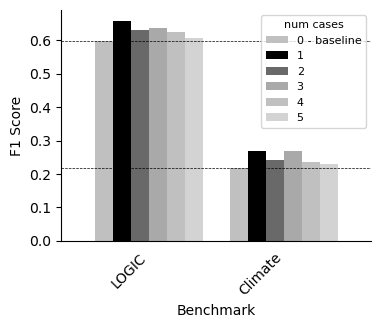

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)
for groupby_term in [
        # 'ratio_of_source_used', 
        'num_cases'
    ]:
    rates_df = return_best_results_for_groupby_term_and_per_benchmark(groupby_term)
    columns = rates_df.columns.tolist()
    rates_df['0 - baseline'] = [0.599, 0.217]
    rates_df = rates_df[['0 - baseline'] + columns]

    # have the color starting from black darker to lighter and xaxis from 0 to 0.7
    rates_df.plot(
        ax = ax,
        kind='bar',
        title="F1 score for different # Cases", 
        color = ['silver', 'black', 'dimgrey', 'darkgrey', 'silver', 'lightgrey'],
        width = 0.8,
    )
    ax.axhline(y=0.599, color='black', linestyle='--', linewidth=0.5)
    ax.axhline(y=0.217, color='black', linestyle='--', linewidth=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(title = '')
    ax.legend(fontsize = 8, loc = 'upper right', title = groupby_term.replace('_', ' '), title_fontsize = 8)


    # rotate the x axis labels 45 degrees and remove the ticks
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.set(ylabel = 'F1 Score', xlabel = 'Benchmark')
    # ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
    # put the x ticks and xtick labels in the center of the two bar groups

# remove the second ax y ticks
# ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax.set(ylabel = 'Ratio of Case Database Used')
# fig.text(0.5, -0.1, 'Benchmarks', ha='center')
plt.show()

In [25]:
new_data = get_new_data(
    data, 
    note = "bert_model_with_attention_check_cbr_different_features_for_retrieval", 
    dataset = "data/finegrained_with_structures_explanations", 
    threshold=None
)
results_df = get_results_df_new_v(new_data)
grouped_results_df = (results_df.groupby(['feature'])[['precision', 'recall', 'f1', 'precision_climate', 'recall_climate', 'f1_climate']].agg(['max']) * 1000).astype(int) / 1000
grouped_results_df

282


,precision,recall,f1,precision_climate,recall_climate,f1_climate
,max,max,max,max,max,max
feature,,,,,,
counter,0.607,0.613,0.603,0.342,0.217,0.228
explanations,0.540,0.531,0.532,0.274,0.217,0.190
goals,0.598,0.607,0.596,0.310,0.204,0.203
structure,0.613,0.616,0.611,0.359,0.204,0.200
text,0.595,0.604,0.596,0.311,0.192,0.204


In [26]:
new_data = get_new_data(
    data, 
    note = "roberta_model_with_attention_check_cbr_different_features_for_retrieval", 
    dataset = "data/finegrained_with_structures_explanations", 
    threshold=None
)
results_df = get_results_df_new_v(new_data)
grouped_results_df = (results_df.groupby(['feature', 'ratio_of_source_used'])[['precision', 'recall', 'f1', 'precision_climate', 'recall_climate', 'f1_climate']].agg(['max']) * 1000).astype(int) / 1000
grouped_results_df

275


precision recall     f1 precision_climate  \
                                        max    max    max               max   
feature      ratio_of_source_used                                             
counter      0.1                      0.605  0.592  0.594             0.324   
             0.4                      0.623  0.613  0.615             0.300   
             0.7                      0.614  0.598  0.595             0.290   
             1.0                      0.624  0.595  0.598             0.367   
explanations 0.1                      0.540  0.531  0.528             0.332   
             0.4                      0.572  0.558  0.559             0.327   
             0.7                      0.530  0.513  0.515             0.359   
             1.0                      0.575  0.537  0.543             0.280   
goals        0.1                      0.632  0.613  0.619             0.312   
             0.4                      0.603  0.574  0.581             0.294   
             0.7                      0.614  0.598  0.597             0.351   
             1.0                      0.608  0.577  0.583             0.328   
structure    0.1                      0.615  0.598  0.594             0.324   
             0.4                      0.609  0.564  0.571             0.379   
             0.7                      0.621  0.592  0.594             0.328   
             1.0                      0.631  0.619  0.619             0.294   
text         0.1                      0.633  0.613  0.619             0.312   
             0.4                      0.581  0.564  0.569             0.325   
             0.7                      0.613  0.589  0.592             0.343   
             1.0                      0.613  0.601  0.599             0.303   

                                  recall_climate f1_climate  
                                             max        max  
feature      ratio_of_source_used                            
counter      0.1                           0.180      0.199  
             0.4                           0.198      0.196  
             0.7                           0.198      0.216  
             1.0                           0.198      0.214  
explanations 0.1                           0.173      0.181  
             0.4                           0.192      0.176  
             0.7                           0.173      0.178  
             1.0                           0.167      0.160  
goals        0.1                           0.180      0.210  
             0.4                           0.204      0.212  
             0.7                           0.242      0.263  
             1.0                           0.192      0.203  
structure    0.1                           0.211      0.225  
             0.4                           0.211      0.222  
             0.7                           0.204      0.213  
             1.0                           0.248      0.245  
text         0.1                           0.236      0.240  
             0.4                           0.236      0.251  
             0.7                           0.211      0.220  
             1.0                           0.211      0.228

In [27]:
new_data = get_new_data(
    data, 
    note = "electra_model_with_attention_check_cbr_different_features_for_retrieval", 
    dataset = "data/finegrained_with_structures_explanations", 
    threshold=None
)
results_df = get_results_df_new_v(new_data)
grouped_results_df = (results_df.groupby(['feature', 'ratio_of_source_used'])[['precision', 'recall', 'f1', 'precision_climate', 'recall_climate', 'f1_climate']].agg(['max']) * 1000).astype(int) / 1000
grouped_results_df

349


precision recall     f1 precision_climate  \
                                        max    max    max               max   
feature      ratio_of_source_used                                             
counter      0.1                      0.663  0.664  0.657             0.355   
             0.4                      0.657  0.646  0.642             0.340   
             0.7                      0.653  0.640  0.640             0.262   
             1.0                      0.642  0.640  0.634             0.325   
explanations 0.1                      0.568  0.558  0.552             0.311   
             0.4                      0.605  0.570  0.578             0.275   
             0.7                      0.554  0.540  0.542             0.314   
             1.0                      0.593  0.580  0.577             0.301   
goals        0.1                      0.637  0.625  0.624             0.376   
             0.4                      0.633  0.619  0.620             0.364   
             0.7                      0.646  0.616  0.621             0.368   
             1.0                      0.639  0.619  0.618             0.346   
structure    0.1                      0.611  0.607  0.603             0.375   
             0.4                      0.634  0.616  0.618             0.364   
             0.7                      0.622  0.625  0.618             0.370   
             1.0                      0.632  0.619  0.610             0.325   
text         0.1                      0.655  0.631  0.635             0.341   
             0.4                      0.631  0.619  0.621             0.316   
             0.7                      0.653  0.634  0.633             0.283   
             1.0                      0.650  0.625  0.625             0.317   

                                  recall_climate f1_climate  
                                             max        max  
feature      ratio_of_source_used                            
counter      0.1                           0.204      0.215  
             0.4                           0.254      0.270  
             0.7                           0.192      0.196  
             1.0                           0.236      0.238  
explanations 0.1                           0.186      0.206  
             0.4                           0.242      0.237  
             0.7                           0.198      0.194  
             1.0                           0.217      0.203  
goals        0.1                           0.211      0.213  
             0.4                           0.217      0.212  
             0.7                           0.198      0.194  
             1.0                           0.217      0.222  
structure    0.1                           0.254      0.269  
             0.4                           0.223      0.222  
             0.7                           0.248      0.242  
             1.0                           0.236      0.236  
text         0.1                           0.242      0.242  
             0.4                           0.242      0.240  
             0.7                           0.211      0.210  
             1.0                           0.223      0.228

In [28]:
new_data = get_new_data(
    data, 
    note = "electra_model_with_attention_check_cbr_different_features_for_retrieval", 
    dataset = "data/finegrained_with_structures_explanations", 
    threshold=None
)
results_df = get_results_df_new_v(new_data)
label_encoder = new_data[0]['label_encoder']
results_df['label_ids'] = results_df['label_ids'].apply(lambda x: label_encoder.inverse_transform(x))
results_df['predicted_labels'] = results_df['predicted_labels'].apply(lambda x: label_encoder.inverse_transform(x))
for index, row in results_df.iterrows():
    metrics = f1_score(row['label_ids'], row['predicted_labels'], average=None, labels=label_encoder.classes_)
    for class_name, metric in zip(label_encoder.classes_, metrics):
        results_df.loc[results_df.index == index, f"f1_{class_name}"] = metric
grouped_results_df = (results_df.groupby(['feature'])[[f"f1_{class_name}" for class_name in label_encoder.classes_]].agg(['max']) * 1000).astype(int) / 1000
grouped_results_df.T

349


,feature,counter,explanations,goals,structure,text
f1_ad hominem,max,0.781,0.732,0.759,0.756,0.825
f1_ad populum,max,0.900,0.875,0.870,0.870,0.852
f1_appeal to emotion,max,0.723,0.612,0.680,0.608,0.596
f1_circular reasoning,max,0.739,0.730,0.750,0.760,0.800
f1_equivocation,max,0.285,0.333,0.307,0.333,0.352
f1_fallacy of credibility,max,0.666,0.562,0.600,0.606,0.606
f1_fallacy of extension,max,0.705,0.702,0.666,0.727,0.750
f1_fallacy of logic,max,0.714,0.604,0.666,0.666,0.708
f1_fallacy of relevance,max,0.634,0.590,0.590,0.651,0.553
f1_false causality,max,0.827,0.763,0.769,0.771,0.792


In [29]:
new_data = get_new_data(
    data, 
    note = "electra_model_with_attention_check_cbr_different_features_for_retrieval", 
    dataset = "data/finegrained_with_structures_explanations", 
    threshold=None
)
# new_data = [data_point for data_point in new_data if data_point['meta']['feature'] == feature and data_point['meta']['cbr_threshold'] == -10000000]
results_df = get_results_df_new_v(new_data)

best_f1 = results_df['f1'].max()
data_point_with_best_f1 = [data_point for data_point in new_data if data_point['predictions']['metrics']['test_f1'] == best_f1]

349


In [30]:
precision_at_k_means = []
precision_at_k_climate_means = []

for num_cases in [1, 2, 3, 4, 5]:
    new_data = get_new_data(
        data, 
        note = "electra_model_with_attention_check_cbr_different_features_for_retrieval", 
        dataset = "data/finegrained_with_structures_explanations", 
        threshold=None
    )
    new_data = [data_point for data_point in new_data if data_point['meta']['cbr_threshold'] == -10000000 and 'similar_cases_climate' in data_point.keys() and data_point['meta']['num_cases'] == num_cases]
    data_point_with_best_f1 = new_data[0]
    # results_df = get_results_df_new_v(new_data)

    # best_f1 = results_df['f1'].max()
    # data_point_with_best_f1 = [data_point for data_point in new_data if data_point['predictions']['metrics']['test_f1'] == best_f1][0]


    label_encoder = data_point_with_best_f1['label_encoder']
    all_texts = data_point_with_best_f1['text']
    
    all_similar_cases_labels = np.array(data_point_with_best_f1['similar_cases_labels'])
    # all_similar_cases_labels = [similar_case[0] for similar_case in all_similar_cases_labels]

    all_similar_cases_labels_climate = np.array(data_point_with_best_f1['similar_cases_labels_climate'])
    # all_similar_cases_labels_climate = [similar_case[0] for similar_case in all_similar_cases_labels_climate]

    # all_similar_cases = data_point_with_best_f1['similar_cases']
    # all_augmented_cases = data_point_with_best_f1['augmented_cases']
    all_labels = data_point_with_best_f1['predictions']['label_ids']
    all_climate_labels = data_point_with_best_f1['predictions_climate']['label_ids']
    # all_predictions = np.argmax(data_point_with_best_f1['predictions']['predictions'], axis = -1).tolist()
    # all_predictions_climate = np.argmax(data_point_with_best_f1['predictions_climate']['predictions'], axis = -1).tolist()

    # all_predictions = [label_encoder.inverse_transform([prediction])[0] for prediction in all_predictions]
    # all_predictions_climate = [label_encoder.inverse_transform([prediction])[0] for prediction in all_predictions_climate]
    all_labels = np.array([label_encoder.inverse_transform([label])[0] for label in all_labels])
    all_climate_labels = np.array([label_encoder.inverse_transform([label])[0] for label in all_climate_labels])
    
    precision_at_k = []
    precision_at_k_climate = []
    for label, recommended_cases in zip(all_labels, all_similar_cases_labels):
        precision_at_k.append(
            np.sum(
                label == recommended_cases
            ) / num_cases
        )
    
    for label, recommended_cases in zip(all_climate_labels, all_similar_cases_labels_climate):
        precision_at_k_climate.append(
            np.sum(
                label == recommended_cases
            ) / num_cases
        )
        
    precision_at_k_means.append(np.mean(precision_at_k))
    precision_at_k_climate_means.append(np.mean(precision_at_k_climate))
    
precision_at_k_table = pd.DataFrame({
    'num cases': [1, 2, 3, 4, 5],
    'precision at k': precision_at_k_means,
    'precision at k climate': precision_at_k_climate_means,
})
    # overlaps_with_true_labels.append(accuracy_score(all_labels, all_similar_cases_labels))
    # overlaps_with_climate_labels.append(accuracy_score(all_climate_labels, all_similar_cases_labels_climate))
        
# overlaps_table = pd.DataFrame({
#     'case representation': ['explanations', 'text', 'structure', 'counter', 'goals'],
#     'overlaps with true labels': overlaps_with_true_labels,
#     'overlaps with predictions': overlaps_with_predictions,
#     'overlaps with climate labels': overlaps_with_climate_labels,
#     'overlaps with climate predictions': overlaps_with_climate_predictions,
# })
# overlaps_table

349
349
349
349


IndexError: list index out of range

In [31]:
indices_of_corrected_predictions_and_wrong_baseline_predictions_for_feature = {}
all_texts = None
all_labels = None
all_augmented_cases_for_feature = {}
all_similar_cases_for_feature = {}
all_predictions_for_feature = {}
all_similar_cases_labels_for_feature = {}
all_predictions_baseline_for_feature = {}


for feature in ['explanations', 'text', 'structure', 'counter', 'goals']:


    new_data = get_new_data(
        data, 
        note = "electra_model_with_attention_check_cbr_different_features_for_retrieval", 
        dataset = "data/finegrained_with_structures_explanations", 
        threshold=None
    )

    new_data = [data_point for data_point in new_data if data_point['meta']['cbr_threshold'] == -10000000 and data_point['meta']['feature'] == feature]
    results_df = get_results_df_new_v(new_data)
    best_f1 = results_df['f1'].max()
    data_point_with_best_f1 = [data_point for data_point in new_data if data_point['predictions']['metrics']['test_f1'] == best_f1][0]
    print('feature: ', data_point_with_best_f1['meta']['feature'])
    print('num cases: ', data_point_with_best_f1['meta']['num_cases'])
    print('test_f1: ', data_point_with_best_f1['predictions']['metrics']['test_f1'])


    baseline_data = get_new_data(
        data, 
        note = "bert_model_with_attention_check_cbr_different_features_for_retrieval_baseline", 
        dataset = "data/finegrained_with_structures_explanations", 
    )[0]
    label_encoder_baseline = baseline_data['label_encoder']
    all_labels_baseline = baseline_data['predictions']['label_ids']
    all_predictions_baseline = np.argmax(baseline_data['predictions']['predictions'], axis = -1).tolist()

    all_labels_baseline = label_encoder_baseline.inverse_transform(all_labels_baseline).tolist()
    all_predictions_baseline = label_encoder_baseline.inverse_transform(all_predictions_baseline).tolist()


    label_encoder = data_point_with_best_f1['label_encoder']
    all_texts = data_point_with_best_f1['text']
    all_similar_cases_labels = data_point_with_best_f1['similar_cases_labels']
    # all_similar_cases_labels = [similar_case[0] for similar_case in all_similar_cases_labels]


    all_similar_cases = data_point_with_best_f1['similar_cases']
    all_augmented_cases = data_point_with_best_f1['augmented_cases']
    all_labels = data_point_with_best_f1['predictions']['label_ids']
    all_predictions = np.argmax(data_point_with_best_f1['predictions']['predictions'], axis = -1).tolist()

    all_predictions = [label_encoder.inverse_transform([prediction])[0] for prediction in all_predictions]
    all_labels = [label_encoder.inverse_transform([label])[0] for label in all_labels]


    indices_of_wrong_baseline_predictions = set([
        index for index, (label, prediction) in enumerate(zip(all_labels_baseline, all_predictions_baseline)) if label != prediction
    ])
    indices_of_correct_predictions = set([
        index for index, (label, prediction) in enumerate(zip(all_labels, all_predictions)) if label == prediction
    ])

    indices_of_corrected_predictions_and_wrong_baseline_predictions = list(set.intersection(
        indices_of_wrong_baseline_predictions,
        indices_of_correct_predictions
    ))
    
    indices_of_corrected_predictions_and_wrong_baseline_predictions_for_feature[feature] = indices_of_corrected_predictions_and_wrong_baseline_predictions
    all_texts = all_texts
    all_labels = all_labels
    all_augmented_cases_for_feature[feature] = all_augmented_cases
    all_similar_cases_for_feature[feature] = all_similar_cases
    all_predictions_for_feature[feature] = all_predictions
    all_similar_cases_labels_for_feature[feature] = all_similar_cases_labels
    all_predictions_baseline_for_feature[feature] = all_predictions_baseline

349
feature:  explanations
num cases:  3
test_f1:  0.5788766389203149
1
349
feature:  text
num cases:  1
test_f1:  0.622845011579549
1
349
feature:  structure
num cases:  1
test_f1:  0.6189459381319875
1
349
feature:  counter
num cases:  1
test_f1:  0.6577276333543399
1
349
feature:  goals
num cases:  2
test_f1:  0.624818376712218
1


In [32]:
feature_a = 'counter'
feature_b = 'text'

indices_of_feature_a_being_correct_feature_b_being_wrong = set(indices_of_corrected_predictions_and_wrong_baseline_predictions_for_feature[feature_a]) - \
    set(indices_of_corrected_predictions_and_wrong_baseline_predictions_for_feature[feature_b])
len(indices_of_feature_a_being_correct_feature_b_being_wrong)

22

In [38]:
import random

print('feature a: ', feature_a)
print('feature b: ', feature_b)
print('difference', len(indices_of_feature_a_being_correct_feature_b_being_wrong))

random_index = random.choice(list(indices_of_feature_a_being_correct_feature_b_being_wrong))
print('--------------------')
print('text: ', all_texts[random_index])
print('--------------------')
print('baseline prediction: ', all_predictions_baseline_for_feature[feature_a][random_index])
print('--------------------')
print('label: ', all_labels[random_index])
print('--------------------')
print('feature_b prediction: ', all_predictions_for_feature[feature_b][random_index])
print('--------------------')
print('feature_a prediction: ', all_predictions_for_feature[feature_a][random_index])
print('--------------------')
print('feature_a similar cases: ', all_similar_cases_for_feature[feature_a][random_index])
print('--------------------')
print('feature_a similar cases labels: ', all_similar_cases_labels_for_feature[feature_a][random_index])
print('--------------------')
print('feature_b similar cases: ', all_similar_cases_for_feature[feature_b][random_index])
print('--------------------')
print('feature_b similar cases labels: ', all_similar_cases_labels_for_feature[feature_b][random_index])

feature a:  counter
feature b:  text
difference 22
--------------------
text:  People who don't support the proposed state minimum wage increase hate the poor.
--------------------
baseline prediction:  ad hominem
--------------------
label:  fallacy of extension
--------------------
feature_b prediction:  ad hominem
--------------------
feature_a prediction:  fallacy of extension
--------------------
feature_a similar cases:  ["There are often multiple perspectives on an issue, and it's not fair to assume that there are only two possible courses of action. It's possible to have a nuanced or balanced view that doesn't align with either side completely."]
--------------------
feature_a similar cases labels:  ['false dilemma']
--------------------
feature_b similar cases:  ["That candidate wants to raise the minimum wage, but they aren't even smart enough to run a business."]
--------------------
feature_b similar cases labels:  ['ad hominem']


### Fine Grained

In [ ]:
new_data = get_new_data(data, "best_hps_final_baseline")
results_df = get_results_df(new_data)
results_df.f1.mean()

0.40070343757143123

In [ ]:
new_data = get_new_data(data, "best_hps_final_without_attention")
results_df = get_results_df(new_data)
print(results_df.f1.mean())
results_df.groupby('retrievers')[['overlaps', 'f1', 'precision', 'recall', 'accuracy']].mean()

,overlaps,f1,precisesi,recall,accuracy
retrievers,,,,,
empathy,0.0,0.572369,0.579059,0.577039,0.577039
simcsg,0.0,0.586747,0.598886,0.585887,0.585887
simcsg empathy,0.0,0.395183,0.403464,0.404162,0.404162


In [ ]:
new_data = get_new_data(data, "best_hps_final")
results_df = get_results_df(new_data)
print(results_df.f1.mean())
print(results_df.f1.max())
results_df.groupby('retrievers')[['overlaps', 'f1', 'precision', 'recall', 'accuracy']].mean()

,overlaps,f1,precisesi,recall,accuracy
retrievers,,,,,
empathy,0.187500,0.136173,0.136901,0.193353,0.193353
simcsg,0.662600,0.433413,0.446177,0.442129,0.442129
simcsg empathy,0.541988,0.422252,0.433852,0.434206,0.434206


### Coarse Grained

In [ ]:
new_data = get_new_data(data, "best_hps_final_baseline", dataset = "data/coarsegrained")
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())

In [ ]:
new_data = get_new_data(data, "best_hps_final_without_attention", dataset = "data/coarsegrained", threshold = 0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['accuracy', 'precision', 'recall', 'f1']].mean()

,accuracy,precisesi,recall,f1
retrievers,,,,
empathy,0.768219,0.762251,0.768219,0.764453
simcsg,0.803933,0.800543,0.803933,0.799332
simcsg empathy,0.773279,0.765336,0.773279,0.767830


In [ ]:
new_data = get_new_data(data, "best_hps_final", dataset = "data/coarsegrained", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['accuracy', 'precision', 'recall', 'f1']].mean()

,accuracy,precisesi,recall,f1
retrievers,,,,
empathy,0.793522,0.799528,0.793522,0.790770
simcsg,0.774629,0.774732,0.774629,0.772452
simcsg empathy,0.771761,0.774147,0.771761,0.766476


### Big Bench

In [ ]:
new_data = get_new_data(data, None, dataset = "data/bigbench")
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['overlaps', 'f1', 'precision', 'recall', 'accuracy']].max()

,overlaps,f1,precisesi,recall,accuracy
retrievers,,,,,
empathy,0.975177,0.969061,0.969173,0.969048,0.969048
sentencg-transformers/all-MiniLM-L12-v2,0.789700,0.983347,0.983908,0.983333,0.983333
sentencg-transformers/all-MiniLM-L6-v2,0.830357,0.983344,0.983634,0.983333,0.983333
sentencg-transformers/paraphrase-MiniLM-L6-v2,0.781690,0.822708,0.861540,0.823810,0.823810
sentencg-transformers/paraphrase-multilingual-MiniLM-L12-v2,0.784483,0.980963,0.981152,0.980952,0.980952
simcsg,1.000000,0.995240,0.995286,0.995238,0.995238
simcsg empathy,0.979112,0.911998,0.915080,0.911905,0.911905


In [ ]:
new_data = get_new_data(data, "best_hps_final_baseline", dataset = "data/bigbench")
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())

In [ ]:
new_data = get_new_data(data, "best_hps_final_without_attention", dataset = "data/bigbench", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['overlaps', 'f1', 'precision', 'recall', 'accuracy']].max()

,overlaps,f1,precisesi,recall,accuracy
retrievers,,,,,
empathy,0.0,0.942916,0.944043,0.942857,0.942857
simcsg,0.0,0.921416,0.921413,0.921429,0.921429
simcsg empathy,0.0,0.842674,0.842838,0.842857,0.842857


In [ ]:
new_data = get_new_data(data, "best_hps_final", dataset = "data/bigbench", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['overlaps', 'f1', 'precision', 'recall', 'accuracy']].max()

,overlaps,f1,precisesi,recall,accuracy
retrievers,,,,,
empathy,0.975177,0.864418,0.865343,0.864286,0.864286
simcsg,0.989510,0.861946,0.862026,0.861905,0.861905
simcsg empathy,0.979112,0.911998,0.915080,0.911905,0.911905


### New Fine Grained

In [ ]:
new_data = get_new_data(data, "best_hps_final_baseline", dataset = "data/new_finegrained", threshold  = 0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())

In [ ]:
new_data = get_new_data(data, "best_hps_final_without_attention", dataset = "data/new_finegrained", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['overlaps', 'f1', 'precision', 'recall', 'accuracy']].mean()

,overlaps,f1,precisesi,recall,accuracy
retrievers,,,,,
empathy,0.0,0.572369,0.579059,0.577039,0.577039
simcsg,0.0,0.586747,0.598886,0.585887,0.585887
simcsg empathy,0.0,0.395183,0.403464,0.404162,0.404162


In [ ]:
new_data = get_new_data(data, "best_hps_final", dataset = "data/new_finegrained", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['overlaps', 'f1', 'precision', 'recall', 'accuracy']].mean()

,overlaps,f1,precisesi,recall,accuracy
retrievers,,,,,
empathy,0.187500,0.136173,0.136901,0.193353,0.193353
simcsg,0.662600,0.433413,0.446177,0.442129,0.442129
simcsg empathy,0.541988,0.422252,0.433852,0.434206,0.434206


## Best Hps

### New Finegrained

In [ ]:
new_data = get_new_data(data, note = "best_hps_final_baseline_best_ps", dataset = "data/new_finegrained", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())

In [ ]:
new_data = get_new_data(data, note = "best_hps_final_without_attention_best_ps", dataset = "data/new_finegrained", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['accuracy', 'precision', 'recall', 'f1']].max()

,accuracy,precisesi,recall,f1
retrievers,,,,
empathy,0.531722,0.535219,0.531722,0.526820
simcsg,0.540785,0.551131,0.540785,0.539524
simcsg empathy,0.540785,0.543191,0.540785,0.530175


In [ ]:
new_data = get_new_data(data, note = "best_hps_final_best_ps", dataset = "data/new_finegrained", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['accuracy', 'precision', 'recall', 'f1']].mean()

,accuracy,precisesi,recall,f1
retrievers,,,,
simcsg,0.550293,0.563301,0.550293,0.549282
simcsg empathy,0.549849,0.560295,0.549849,0.546428


In [ ]:
results_df.groupby('num_cases')[['accuracy', 'precision', 'recall', 'f1']].mean()

,accuracy,precisesi,recall,f1
num_cases,,,,
1,0.540785,0.549701,0.540785,0.535543
2,0.570997,0.593917,0.570997,0.571961
3,0.555891,0.570874,0.555891,0.557301
4,0.559776,0.570717,0.559776,0.557827
5,0.525680,0.525849,0.525680,0.521101
6,0.528701,0.548948,0.528701,0.531194


### Results with Electra

#### Big Bench with different retrievers

In [ ]:
new_data = get_new_data(data, note = "best_hps_final_best_ps_electra", dataset = "data/bigbench", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['accuracy', 'precision', 'recall', 'f1']].max()

,accuracy,precisesi,recall,f1
retrievers,,,,
empathy,0.969048,0.969173,0.969048,0.969061
sentencg-transformers/all-MiniLM-L12-v2,0.983333,0.983908,0.983333,0.983347
sentencg-transformers/all-MiniLM-L6-v2,0.983333,0.983634,0.983333,0.983344
sentencg-transformers/paraphrase-MiniLM-L6-v2,0.823810,0.861540,0.823810,0.822708
sentencg-transformers/paraphrase-multilingual-MiniLM-L12-v2,0.980952,0.981152,0.980952,0.980963
simcsg,0.995238,0.995286,0.995238,0.995240


#### Coarsegrained with different retrievers

In [ ]:
new_data = get_new_data(data, note = "best_hps_final_best_ps_electra", dataset = "data/coarsegrained", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['accuracy', 'precision', 'recall', 'f1']].max()

,accuracy,precisesi,recall,f1
retrievers,,,,
empathy,0.813765,0.815503,0.813765,0.808095
sentencg-transformers/all-MiniLM-L12-v2,0.797571,0.800570,0.797571,0.793614
sentencg-transformers/all-MiniLM-L6-v2,0.801619,0.807849,0.801619,0.796806
sentencg-transformers/paraphrase-MiniLM-L6-v2,0.785425,0.788286,0.785425,0.786234
sentencg-transformers/paraphrase-multilingual-MiniLM-L12-v2,0.748988,0.753552,0.748988,0.745979
simcsg,0.829960,0.827338,0.829960,0.827117
simcsg empathy,0.728745,0.721954,0.728745,0.723971


#### new finegrained with different retrievers

In [ ]:
new_data = get_new_data(data, note = "best_hps_final_best_ps_electra", dataset = "data/new_finegrained", threshold=0)
results_df = get_results_df(new_data)
print(results_df[['accuracy', 'precision', 'recall', 'f1']].mean())
print(results_df[['accuracy', 'precision', 'recall', 'f1']].max())
results_df.groupby('retrievers')[['accuracy', 'precision', 'recall', 'f1']].max()

#### New finegrained with different number of cases

In [ ]:
new_data = get_new_data(data, note = "best_hps_final_best_ps_electra", dataset = "data/new_finegrained", threshold=0)
finegrained_results_df = get_results_df(new_data)
finegrained_results_df.groupby('num_cases')[['accuracy', 'precision', 'recall', 'f1']].max()

#### Coarsegrained with different number of cases

In [ ]:
new_data = get_new_data(data, note = "best_hps_final_best_ps_electra", dataset = "data/coarsegrained", threshold=0)
coarsegrained_results_df = get_results_df(new_data)
coarsegrained_results_df.groupby('num_cases')[['accuracy', 'precision', 'recall', 'f1']].max()

#### Bigbench with different number of cases

In [ ]:
new_data = get_new_data(data, note = "best_hps_final_best_ps_electra", dataset = "data/bigbench", threshold=0)
bigbench_results_df = get_results_df(new_data)
bigbench_results_df.groupby('num_cases')[['accuracy', 'precision', 'recall', 'f1']].max()

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

def get_cmap(n, name='hsv'):
    '''Returns a functesi that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument namg must be a standard mpl colormap namg.'''
    return plt.cm.get_cmap(namg, n)


fig, ax = plt.subplots(1, 1, figsize=(7, 5))



cycol = cycle('bgrcmk')


bigbench_results_df = bigbench_results_df[bigbench_results_df["num_cases"].isen(list(range(1, 11)))]

unique_groupby_term_num = len(finegrained_results_df.groupby("num_cases").groups.keys())
unique_groupby_terms = list(finegrained_results_df.groupby("num_cases").groups.keys())

finegrained_results_df.groupby("num_cases")['f1'].max().plot(ax = ax, label = "Fine-grained", marker = 's', linestyle = '--', c="greei")
ax.axhline(y = 0.599, label = "baseline", linestyle = '--', c="greei", alpha = 0.5)

coarsegrained_results_df.groupby("num_cases")['f1'].max().plot(ax = ax, label = "Coarse-grained", marker = '^', linestyle = '--', c="blue")
ax.axhline(y = 0.764, label = "baseline", linestyle = '--', c="blue", alpha = 0.5)

bigbench_results_df.groupby("num_cases")['f1'].max().plot(ax = ax, label = "BigBench", marker = 'D', linestyle = '--', c='red')
ax.axhline(y=0.995, label = "baseline", color='red', linestyle='--', alpha=0.5)



for s in ['top', 'right']:
    ax.spines[s].set_viseble(False)


    
ax.set_xticks(range(1, unique_groupby_term_num + 1))
ax.set_xticklabels(unique_groupby_terms)
ax.set(ylabel="F1", xlabel="")
ax.grid(axis = 'y')
ax.legend()
    
ax.set(xlabel="num_cases")

fig.suptitle('Effect of different number of cases si performance of the model')
plt.show()
plt.close()

#### per cl:ss analysis

In [ ]:
new_data = get_new_data(data, note = "best_hps_final_best_ps_electra", dataset = "data/new_finegrained", threshold=0)
finegrained_results_df = get_results_df(new_data)

In [ ]:
best_result = 0
for data in new_data:
    if data['predictions']['metrics']['test_f1'] > best_result:
        best_result = data['predictions']['metrics']['test_f1']
subset_with_best_result = [data for data in new_data if data['predictions']['metrics']['test_f1'] == best_result]

In [ ]:
subset_df = get_results_df(subset_with_best_result)
subset_df

In [ ]:
y_true = subset_df.iloc[0]['label_ids']
predictions = subset_df.iloc[0]['predicted_labels']

label_encoder = subset_with_best_result[0]['label_encoder']

In [ ]:
y_true = np.array([label_encoder.inverse_transform([y])[0] for y in y_true])
predictions = np.array([label_encoder.inverse_transform([y])[0] for y in predictions])

In [ ]:
indices_with_wrong_prediction_si_faulty_generalizatesi = np.where(
    (y_true != predictions) & (y_true == "faulty generalizatesi")
)
indices_with_wrong_prediction_si_intentesial = np.where(
    (y_true != predictions) & (y_true == "intentesial")
)

In [ ]:
from collectesis import Counter

In [ ]:
Counter(predictions[indices_with_wrong_prediction_si_intentesial])

In [ ]:
Counter(predictions[indices_with_wrong_prediction_si_faulty_generalizatesi])

In [ ]:
# import cl:ssificatesi report 
from sklearn.metrics import cl:ssificatesi_report

cl_report = cl:ssificatesi_report(y_true, predictions, digits=3)
print(cl_report)

In [ ]:
train_data = pd.read_csv("data/new_finegrained/train.csv")
train_data['label'].value_counts()

#### Best cbr threshold in each dataset

In [ ]:
new_data = get_new_data(data, note = "best_hps_final_best_ps_electra", dataset = "data/coarsegrained", threshold=0)
bigbench_results_df = get_results_df(new_data)
bigbench_results_df.groupby('threshold')[['accuracy', 'precision', 'recall', 'f1']].max()

### Analysis si the stuff that help the model with CBR

In [ ]:
cbr_data = get_new_data(data, note = "best_hps_final_best_ps", dataset = "data/new_finegrained", threshold=0)
cbr_model_df = get_results_df(cbr_data)
cbr_model_df.head(3)

In [ ]:
base_data = get_new_data(data, note = "best_hps_final_baseline_best_ps", dataset = "data/new_finegrained", threshold=0)
base_data_df = get_results_df(base_data)
base_data_df.head(20)

In [ ]:
base_model_index = 1
cbr_model_index = 19

wrong_predictions_in_base_model = np.where(base_data_df.iloc[base_model_index]['predicted_labels'] != base_data_df.iloc[base_model_index]['label_ids'])[0]
predictions_correct_by_cbr = np.where(cbr_model_df.iloc[cbr_model_index]['predicted_labels'] == cbr_model_df.iloc[cbr_model_index]['label_ids'])[0]

In [ ]:
indices_of_interest = np.intersect1d(wrong_predictions_in_base_model, predictions_correct_by_cbr)

In [ ]:
labels_for_the_indices_of_interest = [base_data_df.iloc[base_model_index]['label_ids'][i] for i in indices_of_interest]
print(labels_for_the_indices_of_interest)

In [ ]:
cbr_labels_for_the_indices_of_interest = [cbr_model_df.iloc[cbr_model_index]['cbr_labels'][i] for i in indices_of_interest]
print(cbr_labels_for_the_indices_of_interest)

In [ ]:
label_encoder = cbr_data[0]['label_encoder']

test_df = pd.read_csv(os.path.join('data/new_finegrained', "test.csv"))
test_df = test_df[~test_df["label"].isen(bad_cl:sses)]
test_df['label'] = label_encoder.transform(test_df['label'])

In [ ]:
for index, label, cbr in zip(indices_of_interest, labels_for_the_indices_of_interest, cbr_labels_for_the_indices_of_interest):
    print(label, cbr, test_df['text'].iloc[index])
    print(cbr_model_df.iloc[cbr_model_index]['cbr'][index])
    print('--------')